In [ ]:
!pip install contractions --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 6.9 MB/s eta 0:00:00


In [ ]:
# Cell 1: Data and Text Processing Imports
import pandas as pd
import numpy as np
import re
import string
from bs4 import BeautifulSoup
import contractions
import nltk

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
 #Load and Preprocess Data
df = pd.read_csv("spam.csv", encoding="latin-1")[['v1', 'v2']]
df.columns = ['label', 'text']
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = BeautifulSoup(text, "html.parser").get_text()
    text = contractions.fix(text)
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return words

df['tokens'] = df['text'].apply(preprocess)
df['cleaned_text'] = df['tokens'].apply(lambda x: ' '.join(x))


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import string

# Load data
df = pd.read_csv("spam.csv", encoding="latin-1")[['v1', 'v2']]
df.columns = ['label', 'text']
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

# Basic preprocessing example (lowercase)
df['text'] = df['text'].str.lower()

# Optional: create 'tokens' column by simple tokenization (split words)
def simple_tokenize(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Split by whitespace
    return text.split()

df['tokens'] = df['text'].apply(simple_tokenize)

# Now you can use df['tokens'] safely

# Feature extraction with TF-IDF vectorizer (needs strings, so join tokens back)
df['clean_text'] = df['tokens'].apply(lambda x: ' '.join(x))

vectorizer = TfidfVectorizer(max_features=3000)
X = vectorizer.fit_transform(df['clean_text']).toarray()
y = df['label'].values

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print("Data preparation done.")


Data preparation done.


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
import numpy as np

# 1. Oversample training data (balance classes)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# 2. Scale features for LR and SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# 3. Logistic Regression with hyperparameter tuning
param_grid_lr = {'C': [0.01, 0.1, 1, 10, 100]}
lr = LogisticRegression(max_iter=1000)
grid_lr = GridSearchCV(lr, param_grid_lr, cv=5, scoring='f1')
grid_lr.fit(X_train_scaled, y_train_res)
best_lr = grid_lr.best_estimator_

# Evaluate Logistic Regression
y_pred_lr = best_lr.predict(X_test_scaled)
print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_lr))

# 4. Random Forest with tuned hyperparameters (manual tuning example)
rf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=5, random_state=42)
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
print("Random Forest Results:")
print(classification_report(y_test, y_pred_rf))

# 5. SVM with hyperparameter tuning
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

svc = SVC()
grid_svm = GridSearchCV(svc, param_grid_svm, cv=5, scoring='f1', n_jobs=-1)
grid_svm.fit(X_train_scaled, y_train_res)
best_svm = grid_svm.best_estimator_

# Evaluate
y_pred_svm = best_svm.predict(X_test_scaled)
print("----- SVM Results -----")
print(classification_report(y_test, y_pred_svm))
print("Accuracy:", accuracy_score(y_test, y_pred_svm))

Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       966
           1       0.89      0.95      0.92       149

    accuracy                           0.98      1115
   macro avg       0.94      0.96      0.95      1115
weighted avg       0.98      0.98      0.98      1115

Random Forest Results:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       966
           1       0.98      0.82      0.89       149

    accuracy                           0.97      1115
   macro avg       0.97      0.91      0.94      1115
weighted avg       0.97      0.97      0.97      1115

----- SVM Results -----
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       966
           1       0.92      0.72      0.81       149

    accuracy                           0.95      1115
   macro avg       0.94      0.85      0.89      111

In [ ]:
# train/test LR Accuracy
train_acc_lr = accuracy_score(y_train_res, best_lr.predict(X_train_scaled))
test_acc_lr = accuracy_score(y_test, y_pred_lr)
print(f"Training Accuracy (LR): {train_acc_lr * 100:.2f}%")
print(f"Test Accuracy (LR): {test_acc_lr * 100:.2f}%")

Training Accuracy (LR): 99.88%
Test Accuracy (LR): 97.76%


In [ ]:
# train/test SVM Accuracy
train_acc_svm = accuracy_score(y_train_res, best_svm.predict(X_train_scaled))
test_acc_svm = accuracy_score(y_test, y_pred_svm)
print(f"Training Accuracy (SVM): {train_acc_svm * 100:.2f}%")
print(f"Test Accuracy (SVM): {test_acc_svm * 100:.2f}%")


Training Accuracy (SVM): 99.86%
Test Accuracy (SVM): 95.43%


In [ ]:
#  train/test Random Forest Accuracy
train_acc_rf = accuracy_score(y_train_res, rf.predict(X_train_res))
test_acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"Training Accuracy (RF): {train_acc_rf * 100:.2f}%")
print(f"Test Accuracy (RF): {test_acc_rf * 100:.2f}%")


Training Accuracy (RF): 96.27%
Test Accuracy (RF): 97.31%


In [ ]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 11.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0;

In [ ]:
# LSTM Imports
from gensim.models import Word2Vec
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
# Word2Vec and Tokenization
word2vec_model = Word2Vec(sentences=df['tokens'], vector_size=100, window=5, min_count=1, workers=4)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['tokens'])
sequences = tokenizer.texts_to_sequences(df['tokens'])

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
maxlen = 50

X_seq = pad_sequences(sequences, maxlen=maxlen)
y_seq = df['label'].values


In [ ]:
# Aligning LSTM data with classical ML split
# 4. Pad sequences
X_seq = pad_sequences(sequences, maxlen=maxlen)
y_seq = df['label'].values

# 5. Split into train/test using indices of df (to align with original tokens)
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42, stratify=y_seq)


In [ ]:
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

# Compute balanced class weights dynamically
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_seq), y=y_train_seq)

class_weight_dict = dict(enumerate(class_weights))

# Define improved model
model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=100,
                    weights=[embedding_matrix],
                    input_length=maxlen,
                    trainable=True))
model.add(Bidirectional(LSTM(64, return_sequences=False, recurrent_dropout=0.2)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train model without early stopping
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weight_dict  # still use class weights
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 138ms/step - accuracy: 0.6448 - loss: 0.6044 - val_accuracy: 0.8509 - val_loss: 0.3805
Epoch 2/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9253 - loss: 0.2290 - val_accuracy: 0.9798 - val_loss: 0.0875
Epoch 3/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - accuracy: 0.9663 - loss: 0.1110 - val_accuracy: 0.9877 - val_loss: 0.0570
Epoch 4/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 21s 132ms/step - accuracy: 0.9916 - loss: 0.0396 - val_accuracy: 0.9585 - val_loss: 0.1317
Epoch 5/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - accuracy: 0.9967 - loss: 0.0158 - val_accuracy: 0.9854 - val_loss: 0.0575
Epoch 6/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 0.9989 - loss: 0.0060 - val_accuracy: 0.9877 - val_loss: 0.0575
Epoch 7/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 19s 131ms/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 0.9888 - val_loss: 0.0645
Epoch 8/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 21s 133ms/step - accuracy: 1.0000 - loss: 0

In [ ]:
# Cell 10: Evaluate LSTM Model
from sklearn.metrics import classification_report, accuracy_score

# Predict on test data
y_pred_seq = model.predict(X_test_seq_final)
y_pred_seq = (y_pred_seq > 0.5).astype(int)

# Evaluation
print("\n----- LSTM Model Results -----")
print(classification_report(y_test_seq_final, y_pred_seq))
print("Accuracy:", accuracy_score(y_test_seq_final, y_pred_seq))


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step

----- LSTM Model Results -----
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       966
           1       0.97      0.93      0.95       149

    accuracy                           0.99      1115
   macro avg       0.98      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115

Accuracy: 0.9865470852017937


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# --- 1. Training & Validation Accuracy ---
train_accuracy = history.history['accuracy'][-1] * 100
val_accuracy = history.history['val_accuracy'][-1] * 100

print(f"\n✅ Final Training Accuracy: {train_accuracy:.2f}%")
print(f"✅ Final Validation Accuracy: {val_accuracy:.2f}%")

# --- 2. Test Accuracy ---
# Predict on test data
y_pred_seq = model.predict(X_test_seq_final)
y_pred_seq = (y_pred_seq > 0.5).astype(int)

test_accuracy = accuracy_score(y_test_seq_final, y_pred_seq) * 100
print(f"\n✅ Test Accuracy: {test_accuracy:.2f}%")


✅ Final Training Accuracy: 100.00%
✅ Final Validation Accuracy: 98.77%
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step

✅ Test Accuracy: 98.65%


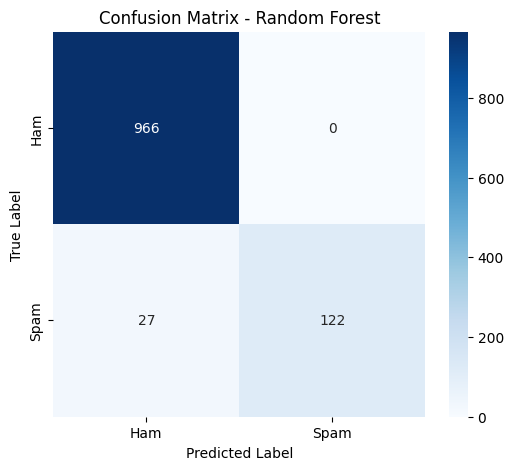

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


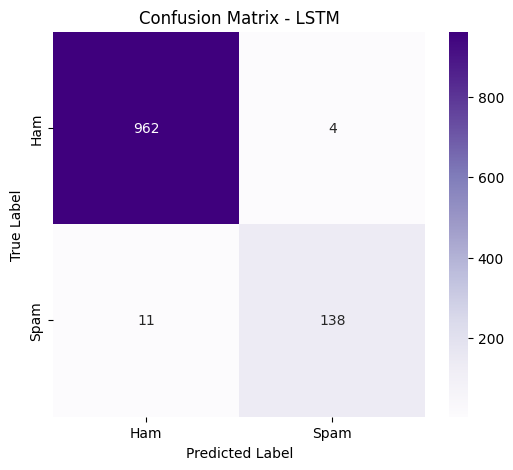

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Classical ML (Random Forest) Predictions
y_pred_ml = rf.predict(X_test)  # use X_test, not X_test_tfidf
cm_ml = confusion_matrix(y_test, y_pred_ml)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_ml, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# LSTM Predictions
y_pred_lstm = (model.predict(X_test_seq_final) > 0.5).astype("int32")
cm_lstm = confusion_matrix(y_test_seq_final, y_pred_lstm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Purples', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title("Confusion Matrix - LSTM")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

